# A Bayesian Fit to ATLAS 4-lepton Open Data

 >**Created**: December 2022, Amsterdam Airport, Harrison B. Prosper<br>
 >**Updated**: Adapted Jun. 20 2024 for AEPSHEP
 

## Introduction

This notebook applies the fit developed in Ref.[1] to perform a signal + background fit to the 2020 ATLAS 4-lepton Open Data. You will need to download the GitHub package $\texttt{pgammafit}$ using:

```bash
git clone https://github.com/hprosper/pgammafit
```
and compile and install it. The statistical model is given by

\begin{align}
    p(D | a, p) & = L(D | a, p) \, \pi(a), \quad\text{where}\\
    L(D | a, p) & = \prod_{i=1}^M \frac{\exp(-d_i) \, d_i^{D_i}}{D_i!},\\
    d_i & = \sum_{j=1}^N p_i \, a_{ji}, \quad\text{and}\\
    \pi(a) & = \prod_{i=1}^M \prod_{j=1}^N \frac{\exp(-a_{ji}) \, a_{ji}^{A_{ji}}}{\Gamma(A_{ji}+1)} .
\end{align}
If $\pi(a, K)$ is interpreted as an informative prior, we can marginalize over the $M \times N$ quantities $a_{ji}$ to find the marginal likelihood,
\begin{align}
    l(D | p) & = \prod_{i=1}^M \sum_{k_1,\cdots,k_N = 0}^{D_i} \prod_{j=1}^N \binom{A_{ji} + k_j}{k_j} \frac{p_j^{k_j}}{\left(1 + p_j^{A_{ji} + k_j + 1}\right)} \text{ with } \sum_{j=1}^N k_j = D_i .
\end{align}
The interpretation of the coefficients $p_j$ depends on the interpretation of the counts $A_{ji}$. For example, suppose that the signal channel corresponds to $j = 1$ and for that channel $A_{1i}$ are the predicted signal counts given the integrated luminosity associated with the observations $\{ D_i \}$. Then $p_1 = \mu = \sigma / \sigma_\text{SM}$, that is, it would be the so-called **signal strength**, where $\sigma_\text{SM}$ is the Standard Model cross section.

### References
  1. P.C. Bhat, H.B. Prosper, S.S. Snyder, *Bayesian analysis of multi-source data*, Phys. Lett. B Volume 407, Issue 1, 21 August 1997, Pages 73-78

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp

import matplotlib.pyplot as plt

# a function to read and save results
import joblib as jb

import pgammafit as pg

import ROOT

%matplotlib inline

Welcome to JupyROOT 6.30/02
loaded pgammafit


In [2]:
# update fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)


# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

mp.rc('text', usetex=False)

### Load data

In [3]:
dat = pd.read_csv('../datasets/atlas_opendata_4l_dat.csv.gz')
print(f'len(dat): {len(dat):8d}')

ggf = pd.read_csv('../datasets/atlas_opendata_4l_ggf.csv.gz')
vbf = pd.read_csv('../datasets/atlas_opendata_4l_vbf.csv.gz')
# concatenate vbf and ggf then randomly shuffle all (frac=1) rows
sig = pd.concat([vbf, ggf]).sample(frac=1)
print(f'len(sig): {len(sig):8d}')

bkg = pd.read_csv('../datasets/atlas_opendata_4l_bkg.csv.gz')
print(f'len(bkg): {len(bkg):8d}')

bkg[:5]

len(dat):      229
len(sig):   236901
len(bkg):   360715


,weight,mass4l,detajj,massjj
0,0.000094,432.846217,3.398400,115.077466
1,0.000107,315.570996,1.782559,75.371308
2,0.000039,237.242107,0.341712,75.902373
3,-0.000199,422.388903,2.089638,67.524406
4,0.000018,91.332645,1.498294,76.053619


In [4]:
print(f'signal: {sig.weight.sum():6.2f} fb, background: {bkg.weight.sum():6.2f} fb')

signal:   0.56 fb, background:  12.81 fb


In [5]:
def get_hist(data, field, xbins=50, xmin=70, xmax=170):
    
    y1, edges = np.histogram(data[field], 
                             weights=data.weight,
                             bins=xbins, 
                             range=(xmin, xmax))
    
    y2, _     = np.histogram(data[field], 
                             weights=data.weight**2,
                             bins=xbins, 
                             range=(xmin, xmax))
    y2 = np.sqrt(y2)
    return edges, y1, y2

def to_vector(a):
    v = ROOT.vector("double")(len(a))
    for i in range(len(a)):
        v[i] = a[i]
    return v

def to_numpy(v):
    a = np.zeros(len(v))
    for i in range(len(v)):
        a[i] = v[i]
    return v

mass4l_data.png


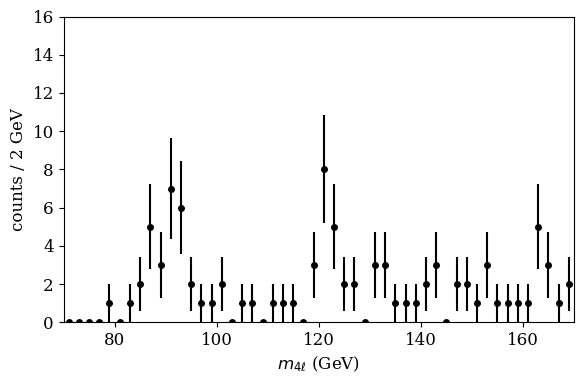

In [6]:
def plot_data(x, D, dD,   
               filename='mass4l_data.png', 
               color='steelblue',
               ymin=0, ymax=16):
    
    # set size of figure
    fig  = plt.figure(figsize=(6, 4))

    # one plot per figure
    nrows, ncols, index = 1, 1, 1
    ax   = fig.add_subplot(nrows, ncols, index)
    
    h    = x[1]-x[0]
    xmin = x[0]
    xmax = x[-1]
    xbins= len(D)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$m_{4\ell}$ (GeV)', fontsize=12)
    ax.set_ylabel(f'counts / {int(h):d} GeV', fontsize=12)

    # get bin centers
    x = (x[1:] + x[:-1])/2

    # plot data
    ax.errorbar(x, D, dD, 
                    fmt='o',  # no lines connecting points
                    color='black',
                    markerfacecolor='black', 
                    markeredgecolor='black', 
                    markersize=4,
                    markeredgewidth=1)
    
    fig.tight_layout()
    print(filename)
    plt.savefig(filename)
    plt.show()

x, D, dD = get_hist(dat, 'mass4l')
plot_data(x, D, dD)  

In [7]:
_, b, dB = get_hist(bkg, 'mass4l')
_, s, dS = get_hist(sig, 'mass4l')

# construct a PoissonGamma object 
pgfit = pg.PoissonGammaFit(to_vector(D), verbosity=-1)

scale = False
sources = []

# add sources (that is, channels)
pgfit.add(to_vector(b), to_vector(dB), scale); sources.append('bkg') 
pgfit.add(to_vector(s), to_vector(dS), scale); sources.append('higgs')

# find mode of posterior density
# make some reasonable guesses
total = np.sum(D)
guess = ROOT.vector("double")(2, 5)
pgfit.execute(guess)

if not pgfit.good():
    raise ValueError('''
        ** :( thou lump of foul deformity - the fit failed!
        ** quit or try better starting guesses for
        ** the source counts in the signal region and/or do some
        ** rebinning, maybe?
        ''')

# get mode and width of posterior density, which, 
# because PoissonGammaFit uses a flat prior for the yields, 
# are the same as those of the Poisson/gamma marginal density. 

mode  = pgfit.mode()
error = pgfit.width()

# scale counts based on result of fit.
B = mode[0] * b
S = mode[1] * s

# Print results
print('')  
print("%-10s  \t   %s" %  \
        ('source', "estimated scales"))
for index, source in enumerate(sources):
    print("%-10s \t%10.1f +/-%-10.1f 1/fb" % \
            (source, mode[index], error[index]))
print()

Stot = S.sum()
Btot = B.sum()
print('total: S = %6.1f, B = %6.1f, S+B = %6.1f' % \
      (Stot, Btot, Stot+Btot))
print("total observed count:               %5d" % total) 


source      	   estimated scales
bkg        	      25.9 +/-3.1        1/fb
higgs      	      26.7 +/-8.5        1/fb

total: S =   15.0, B =   77.6, S+B =   92.6
total observed count:                  93


In [8]:
def plot_fit(x, D, dD, B, S, results,   
               filename='mass4l_fit.png', 
               color='steelblue',
               ymin=0, ymax=16):
    
    # set size of figure
    fig  = plt.figure(figsize=(6, 4)) 
    ax   = fig.add_subplot(1, 1, 1)
    
    h    = x[1]-x[0]
    xmin = x[0]
    xmax = x[-1]
    xbins= len(D)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('$m_{4\ell}$ (GeV)', fontsize=12)
    ax.set_ylabel(f'counts / {int(h):d} GeV', fontsize=12)
    
    x = (x[1:] + x[:-1])/2
    ax.errorbar(x, D, dD, 
                    fmt='o',  # no lines connecting points
                    color='black',
                    markerfacecolor='black', 
                    markeredgecolor='black', 
                    markersize=4,
                    markeredgewidth=1)
    
    X = np.array([list(x), list(x)]).T
    W = np.array([list(B), list(S)]).T
    
    ax.hist(X, weights=W,
                bins=xbins, 
                color=((0.75, 0.02, 0.6), 'steelblue'),
                histtype='stepfilled',
                alpha=0.5,
                range=(xmin, xmax), stacked=True)
    
    Dsum = D.sum()
    Bsum = B.sum(); Berr = Bsum * error[0]/mode[0]
    Ssum = S.sum(); Serr = Ssum * error[1]/mode[1]
    Tsum = Bsum + Ssum
    Terr = np.sqrt(Berr**2+Serr**2)
    
    xpos = xmin + 0.55*(xmax-xmin)
    ystep= (ymax-ymin)/12
    ypos = ymax-ystep

    ax.text(xpos-10, ypos, 'Fit results'); ypos -= ystep
    
    ax.text(xpos, ypos, 'bkg  (count): %6.1f $\pm %-6.1f$' % \
            (Bsum, Berr), 
            color=(0.75, 0.02, 0.6)); ypos -= ystep
    
    ax.text(xpos, ypos, 'sig  (count): %6.1f $\pm %-6.1f$' % \
            (Ssum, Serr), 
            color='blue'); ypos -= ystep
    
    ax.text(xpos, ypos, 'total(count): %6.1f $\pm %-6.1f$' % \
            (Tsum, Terr), 
            color='black'); ypos -= ystep
    
    ax.text(xpos, ypos, 'data (count): %6d' % Dsum, 
            color='black')
    
    fig.tight_layout()
    print(filename)
    plt.savefig(filename)
    plt.show()

mass4l_fit.png


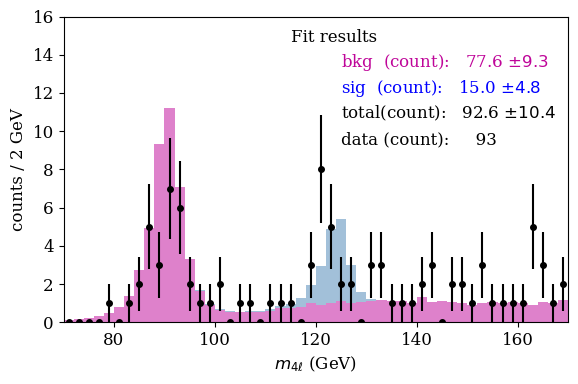

In [9]:
plot_fit(x, D, dD, B, S, [mode, error])  